# Diffusion coefficient from a VASP file

[Previously](./vasp_msd.html), we looked at obtaining accurate estimates for the mean-squared displacement with `kinisi`. 
Here, we show using the same class to evaluate the diffusion coefficient, using the `kinisi` [methodology](./methodology.html).

In [1]:
import numpy as np
from kinisi.analyze import DiffusionAnalyzer
from pymatgen.io.vasp import Xdatcar
np.random.seed(42)

There the `p_params` dictionary describes details about the simulation, and are documented in the [parser module](./parser.html).

In [2]:
p_params = {'specie': 'Li',
            'time_step': 2.0,
            'step_skip': 50,
            'min_obs': 50}

While the `b_params` dictionary describes the details of the bootstrapping process, these are documented in the [diffusion module](./diffusion.html#kinisi.diffusion.MSDBootstrap). Here, we indicate that we only want to investigate diffusion in the *xy*-plane of the system.

In [3]:
b_params = {'dimension': 'xy'}

In [4]:
xd = Xdatcar('./example_XDATCAR.gz')
diff = DiffusionAnalyzer.from_Xdatcar(xd, parser_params=p_params, bootstrap_params=b_params)

Bootstrapping Displacements:  57%|██████████████████████████████████████████████████████████████████████████████▍                                                          | 79/138 [00:05<00:03, 16.82it/s]/Users/andrewmccluskey/software/kinisi/kinisi/diffusion.py:242: UserWarning: The maximum number of resamples has been reached, and the distribution is not yet normal.
  warnings.warn("The maximum number of resamples has been reached, and the distribution is not yet normal.")
Bootstrapping Displacements: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:11<00:00, 11.53it/s]


In the above cells, we parse and determine the uncertainty on the mean-squared displacement as a function of the timestep. 
We should visualise this, to check that we are observing diffusion in our material and to determine the timescale at which this diffusion begins. 

In [5]:
import matplotlib.pyplot as plt

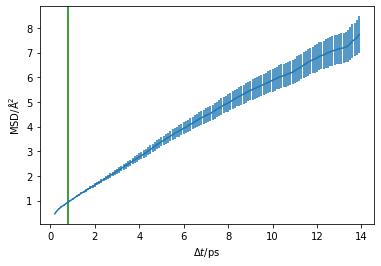

In [6]:
plt.errorbar(diff.dt, diff.msd, diff.msd_std)
plt.axvline(diff.ngp_max, color='g')
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.show()

The vertical green line indicates the start of the diffusive regime, based on the maximum of the [non-Gaussian parameter](https://doi.org/10.1073/pnas.1900239116). 
We can also visualise this on a log-log scale, which helps to reveal the diffusive regime. 

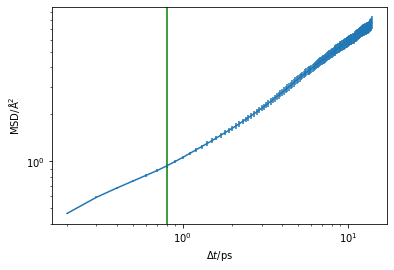

In [7]:
plt.errorbar(diff.dt, diff.msd, diff.msd_std)
plt.axvline(diff.ngp_max, color='g')
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.yscale('log')
plt.xscale('log')
plt.show()

It appears that the non-Gaussian parameter does an okay job at predicting the start of the diffusive regime for this system, so we will set `use_ngp` to `True` such that this is used in the fitting.
If we wanted to use a different estimate, say 4 ps which looks more like the real start, we could use the keyword argument of `dt_skip=4`. 
The `d_params` dictionary defines parameters about the diffusion estimation, documented in the [diffusion module](https://kinisi.readthedocs.io/en/latest/diffusion.html#kinisi.diffusion.MSDBootstrap). 

In [8]:
d_params = {'use_ngp': True}

We can then run the diffusion analysis as follows. 

In [9]:
diff.diffusion(d_params)

/Users/andrewmccluskey/software/kinisi/kinisi/matrix.py:25: UserWarning: The estimated covariance matrix was not positive definite, the nearest positive definite matrix has been found and will be used.
  warnings.warn("The estimated covariance matrix was not positive definite, the nearest positive "
/Users/andrewmccluskey/mambaforge/envs/kinisi/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
Likelihood Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 738.73it/s]


This method estimates the correlation matrix between the timesteps and uses likelihood sampling to find the diffusion coefficient, $D$ and intercept (the units are cm\ :sup:`2`\ /s and Å\ :sup:`2`  respectively).
Now we can probe these objects.

We can get the median and 95 % confidence interval using, 

In [10]:
diff.D, diff.intercept

((9.006+/-0.947)e-6, (5.529+/-0.407)e-1)

Or we can get all of the sampled values from one of these objects. 

In [11]:
diff.D.samples

array([9.09433686e-06, 8.69838157e-06, 9.97214348e-06, ...,
       8.66174398e-06, 8.64302076e-06, 8.79385108e-06])

Having completed the analysis, we can save the object for use later (such as downstream by a plotting script). 

These hidden cells exist to remove any existing `example.hdf` file on builiding.

In [12]:
!rm example.hdf

In [13]:
diff.save('example.hdf')

The data is saved in a HDF5 file format which helps us efficiently store our data. 
We can then load the data with the following class method. 

In [14]:
loaded_diff = DiffusionAnalyzer.load('example.hdf')

We can plot the data with the credible intervals from the $D$ and $D_{\text{offset}}$ distribution (the `60000` is to convert the units).

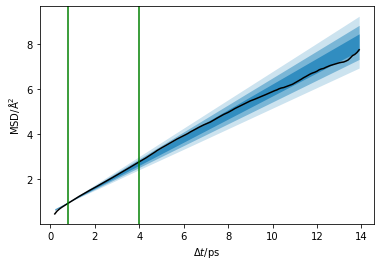

In [15]:
credible_intervals = [[16, 84], [2.5, 97.5], [0.15, 99.85]]
alpha = [0.6, 0.4, 0.2]

plt.plot(loaded_diff.dt, loaded_diff.msd, 'k-')
for i, ci in enumerate(credible_intervals):
    plt.fill_between(loaded_diff.dt,
                     *np.percentile(loaded_diff.distribution, ci, axis=1),
                     alpha=alpha[i],
                     color='#0173B2',
                     lw=0)
plt.axvline(loaded_diff.ngp_max, color='g')
plt.axvline(4, color='g')
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.savefig('_static/example.pdf')

Additionally, we can visualise the distribution of the diffusion coefficient that has been determined.

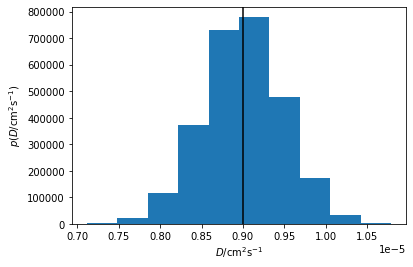

In [16]:
plt.hist(loaded_diff.D.samples, density=True)
plt.axvline(loaded_diff.D.n, c='k')
plt.xlabel('$D$/cm$^2$s$^{-1}$')
plt.ylabel('$p(D$/cm$^2$s$^{-1})$')
plt.show()

Or the joint probability distribution for the diffusion coefficient and intercept.

In [17]:
from corner import corner

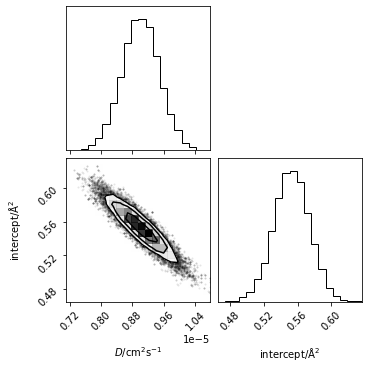

In [18]:
corner(loaded_diff.flatchain, labels=['$D$/cm$^2$s$^{-1}$', 'intercept/Å$^2$'])
plt.show()